In [4]:
from lrgsglib.core import *
import emd
from scipy.signal import decimate, butter, sosfiltfilt, hilbert
from sklearn.cluster import KMeans
#
move_to_rootf()
#
giampiero_mat_path = Path('data') / 'real_data' / 'brain' / 'Pat_02'
#

Current working directory: /home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib


In [5]:
ch_names = loadmat(giampiero_mat_path / 'ChannelNames.mat')
ch_names_list = [name[0] for name in ch_names["ChannelNames"][0]]
nodemap = {i: ch_names_list[i] for i in range(len(ch_names_list))}

In [6]:
pretask_ts = loadmat(giampiero_mat_path / 'Resting_PreTask_Data.mat')
data = pretask_ts['Data'] # shape: (n_channels, n_samples)
rec = pretask_ts['Parameters'][0, 0]
sample_rate = float(rec['fs'][0][0])
fcut_high = float(rec['fcutHigh'][0][0])
fcut_low = float(rec['fcutLow'][0][0])
filter_order = int(rec['filter_order'][0][0])
n_channels, n_samples = data.shape
#
print(f"Freq. range: {fcut_low}-{fcut_high} Hz")
print(f"Sampling rate: {sample_rate} Hz")
print(f"Filter order: {filter_order}")
print(f"Number of channels: {n_channels}")
print(f"Number of samples: {n_samples}")

Freq. range: 0.53-300.0 Hz
Sampling rate: 2048.0 Hz
Filter order: 4
Number of channels: 117
Number of samples: 1323208


In [7]:
bands = {
    'delta':      (0.53,   4),
    'theta':      (4,      8),
    'alpha':      (8,     13),
    'beta':       (13,    30),
    'low_gamma':  (30,    80),
    'high_gamma': (80,   300),
}


In [8]:
def bandpass_sos(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    sos = butter(order, [lowcut/nyq, highcut/nyq], btype='band', output='sos')
    # axis=1 filters each channel (rows are channels)
    return sosfiltfilt(sos, data, axis=1)

# --- 4. Build one corr-network per band -----------------------------------
corr_nets = {}

for band_name, (low, high) in bands.items():
    # 4a) filter all channels at once
    filt = bandpass_sos(data, low, high, sample_rate, filter_order)
    
    # 4b) compute full correlation matrix
    C = np.corrcoef(filt)
    C[C < 0] = 0
    np.fill_diagonal(C, 0)

    corr_nets[band_name] = C

In [19]:
C = corr_nets['beta'].copy()
G = nx.from_numpy_array(C)
Th, Einf, Pinf = compute_threshold_stats(G)
th = 0.4
C[C < th] = 0
G = nx.from_numpy_array(C)
Gcc = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(Gcc)
# get the nodes not in the giant component
not_in_giant = set(G.nodes()) - set(Gcc.nodes())

Computing threshold stats:   0%|          | 0/400 [00:00<?, ?it/s]

Computing threshold stats: 100%|██████████| 400/400 [00:12<00:00, 31.62it/s]


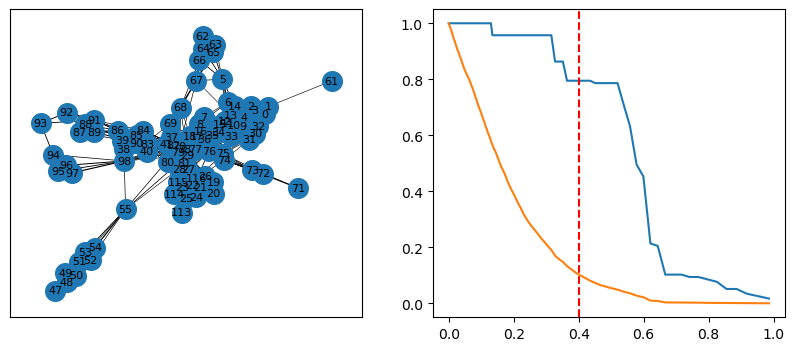

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pos = nx.spring_layout(Gcc, seed=0)
weights = [Gcc[u][v]['weight'] for u, v in Gcc.edges()]  # scale widths
nx.draw_networkx_nodes(Gcc, pos, ax=ax[0], node_size=200)
nx.draw_networkx_labels(Gcc, pos, ax=ax[0], font_size=8)
nx.draw_networkx_edges(Gcc, pos, ax=ax[0], width=weights)
ax[1].plot(Th, Pinf)
ax[1].plot(Th, Einf)
ax[1].axvline(x=th, color='r', linestyle='--')

In [21]:
#
PreTaskThEntropy = entropy(Gcc, t1=-3, t2=5, steps=400)
tau_scale = PreTaskThEntropy[-1]
speC = PreTaskThEntropy[1]/PreTaskThEntropy[1].max()
Sm1 = PreTaskThEntropy[0]/PreTaskThEntropy[0].max()
#

/home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/PhD/projects/complex-networks/lrgsglib/src/lrgsglib/core.py:645: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


In [22]:
spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, Gcc, method='ward')
FlatClusteringTh , *_ = compute_optimal_threshold(linkage_matrix)

In [27]:
FlatClusteringTh =1e-1
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

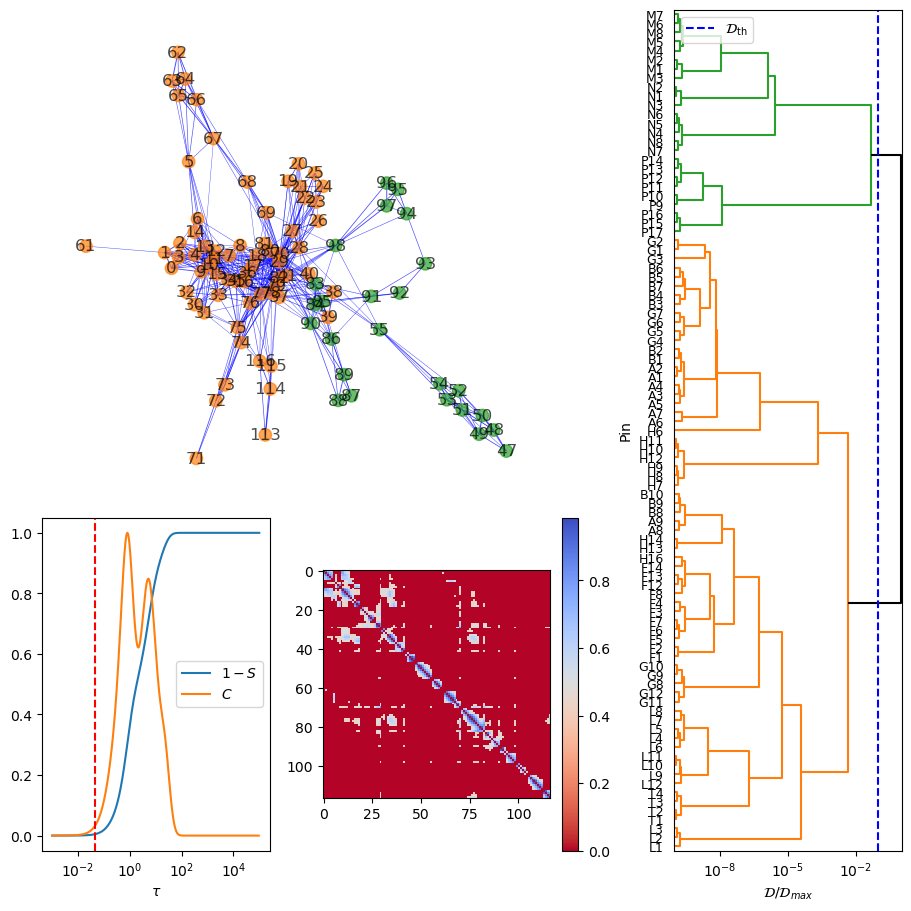

In [28]:
fig = plt.figure(constrained_layout=True,figsize=(9, 9))
#
ax_dict = fig.subplot_mosaic(
    """
    DDDDEE
    DDDDEE
    DDDDEE
    CCBBEE
    CCBBEE
    """
)
#
# ax_dict['A'].plot(Th, Einf, label=r"$E_{\infty}$")
# ax_dict['A'].plot(Th, Pinf, label=r"$P_{\infty}$")
# ax_dict['A'].axvline(x=th, color='r', linestyle='--')
# ax_dict['A'].legend()
#
im = ax_dict['B'].imshow(C, cmap='coolwarm_r', interpolation='none')
#
ax_dict['C'].plot(tau_scale, Sm1, label=r'$1-S$')
ax_dict['C'].plot(tau_scale[:-1], speC, label=r'$C$')
ax_dict['C'].set_xscale('log')
ax_dict['C'].legend()
ax_dict['C'].set_xlabel(r"$\tau$")
ax_dict['C'].axvline(tau, color = 'r', 
    linestyle = '--', )
#
relabel_list = [nodemap[nd] for nd in label_list]
dendro = dendrogram(linkage_matrix, ax=ax_dict['E'], 
                    color_threshold=FlatClusteringTh,
    above_threshold_color='k', leaf_font_size=9,
    labels=relabel_list, orientation='right')
tmin = linkage_matrix[::, 2][0] - 0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1] + 0.1*linkage_matrix[::, 2][-1]
#
ax_dict['E'].axvline(
    FlatClusteringTh, 
    color = 'b', 
    linestyle = '--', 
    label=r"$\mathcal{D}_{\rm th}$")
ax_dict['E'].set_xscale('log')
ax_dict['E'].set_xlim(tmin,tmax)
ax_dict['E'].legend()
ax_dict['E'].set_xlabel(r"$\mathcal{D}/\mathcal{D}_{max}$")
ax_dict['E'].set_ylabel('Pin')
#
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for label in relabel_list]
edge_weights = np.array([Gcc[u][v].get("weight", 1.0) for u, v in Gcc.edges()])
edge_widths = 0.3 + 0.5 * (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in Gcc.edges(data=True)]
pos = nx.spring_layout(Gcc, seed=5)

#
nx.draw(Gcc, pos=pos, ax=ax_dict['D'], node_size=80, width=edge_widths, edge_color=edge_colors, node_color=node_colors,alpha=0.7, with_labels=True)
# plt.margins(0.0)
#
fig.colorbar(im, ax=ax_dict['B'])

<Axes: xlabel='Time (samples)'>

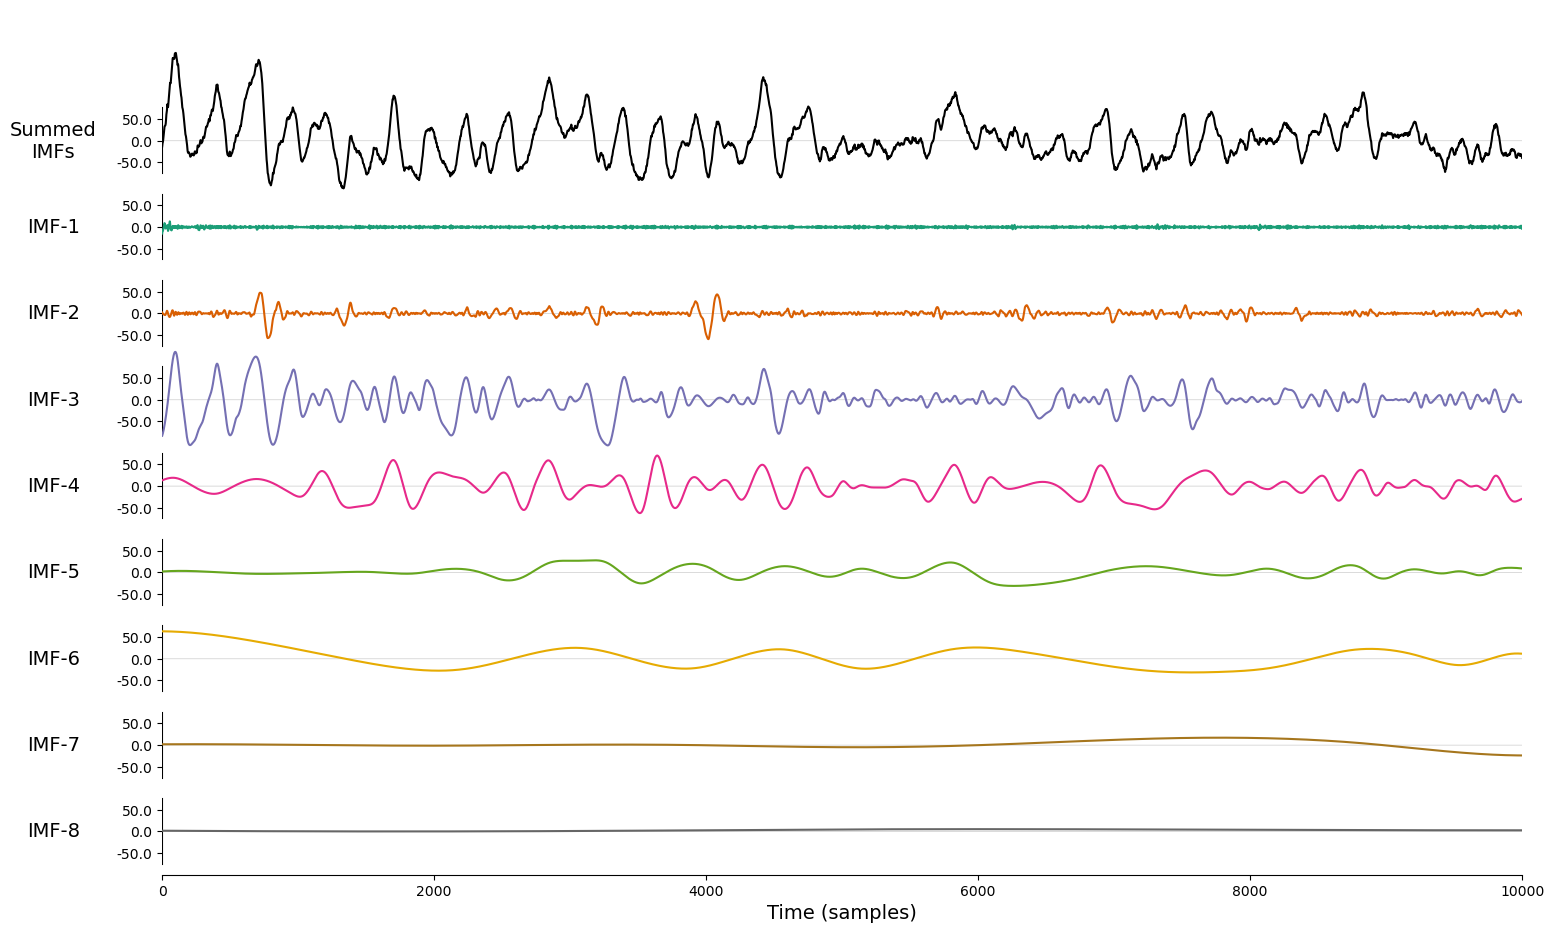

In [46]:
channel_index = 0
signal = data[channel_index,:10000]
imf = emd.sift.sift(signal)
emd.plotting.plot_imfs(imf)

In [ ]:
# 2. Trim to first 10 000 samples
N        = 10_000
data_seg = data[:, :N]
n_channels, _ = data_seg.shape

# 3. Extract IMFs for every channel
imfs_by_ch = []
for ch in range(n_channels):
    sig       = data_seg[ch]
    imf_array = emd.sift.sift(sig)      # → shape (N, n_imfs_ch)
    imfs      = imf_array.T    # → (n_imfs_ch, N)
    imfs_by_ch.append(imfs)

max_imfs = max(imfs.shape[0] for imfs in imfs_by_ch)

In [75]:
corr_nets_imf = {}

# for each IMF index…
for imf_idx in range(max_imfs):
    mats, labels = [], []
    for ch, imfs in enumerate(imfs_by_ch):
        if imf_idx < imfs.shape[0]:
            mats.append(imfs[imf_idx])
            labels.append(ch)
    if len(mats) < 2:
        continue
    
    X = np.vstack(mats)        # (n_valid_ch, N)
    C = np.corrcoef(X)         # (n_valid_ch, n_valid_ch)
    C[C < 0] = 0

    corr_nets_imf[imf_idx] = C

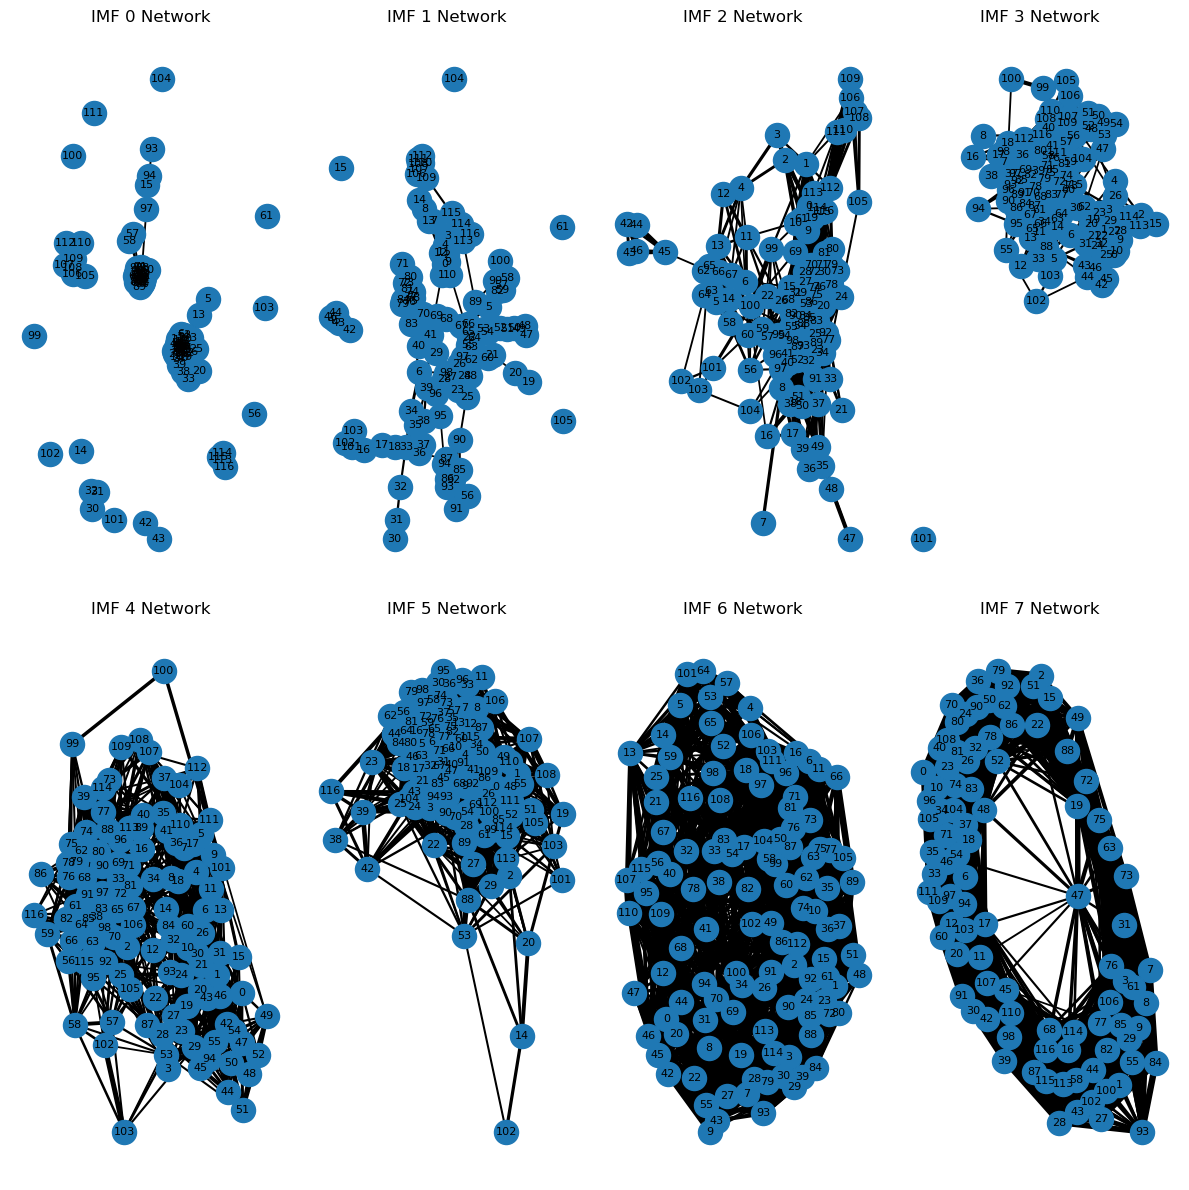

In [74]:
# Plot up to the first 4 IMF networks in a 2×2 grid
imf_ids = list(corr_nets_imf.keys())[:8]
n_plots = len(imf_ids)
rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for ax, imf_idx in zip(axes, imf_ids):
    G = corr_nets_imf[imf_idx]
    # Layout and draw
    pos = nx.spring_layout(G, seed=0)
    weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # scale widths
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=300)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    nx.draw_networkx_edges(G, pos, ax=ax, width=weights)
    ax.set_title(f"IMF {imf_idx} Network")
    ax.axis('off')

# Hide any unused subplots
for i in range(n_plots, rows * cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [62]:
G0 = corr_nets_imf[0]

In [63]:
spectrum, L, rho, Trho, tau = compute_laplacian_properties(G0, tau=None)
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G0, method='ward')
FlatClusteringTh , *_ = compute_optimal_threshold(linkage_matrix)

In [66]:
FlatClusteringTh =2e-3
optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')

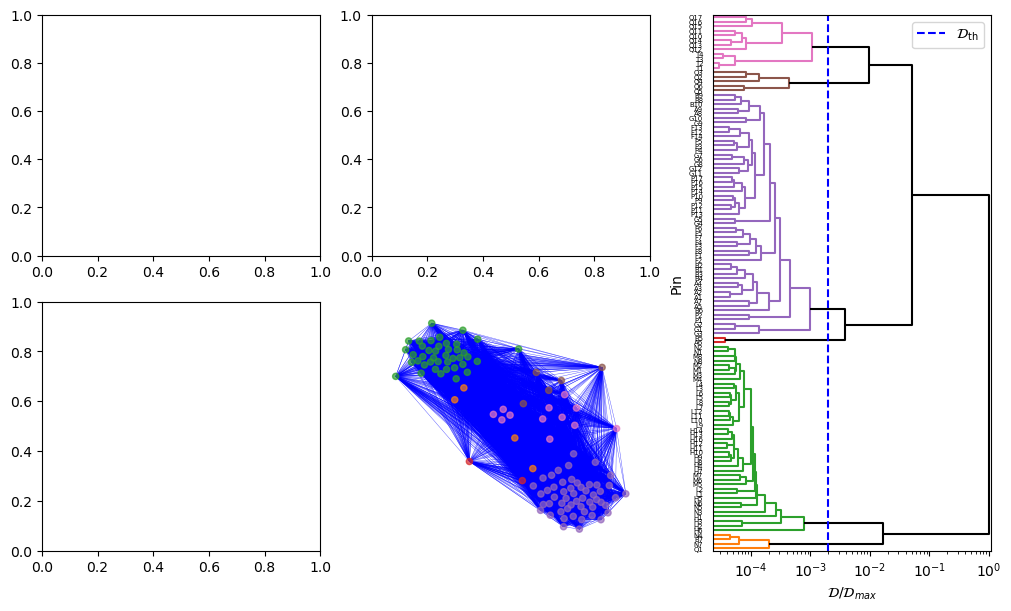

In [67]:
fig = plt.figure(constrained_layout=True,figsize=(10,6))
#
ax_dict = fig.subplot_mosaic(
    """
    AABBEE
    AABBEE
    CCDDEE
    CCDDEE
    """
)
#

#
relabel_list = [nodemap[nd] for nd in label_list]
dendro = dendrogram(linkage_matrix, ax=ax_dict['E'], 
                    color_threshold=FlatClusteringTh,
    above_threshold_color='k',
    labels=relabel_list, orientation='right')
tmin = linkage_matrix[::, 2][0] - 0.2*linkage_matrix[::, 2][0]
tmax = linkage_matrix[::, 2][-1] + 0.1*linkage_matrix[::, 2][-1]
#
ax_dict['E'].axvline(
    FlatClusteringTh, 
    color = 'b', 
    linestyle = '--', 
    label=r"$\mathcal{D}_{\rm th}$")
ax_dict['E'].set_xscale('log')
ax_dict['E'].set_xlim(tmin,tmax)
ax_dict['E'].legend()
ax_dict['E'].set_xlabel(r"$\mathcal{D}/\mathcal{D}_{max}$")
ax_dict['E'].set_ylabel('Pin')
#
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[label] for label in relabel_list]
edge_weights = np.array([G0[u][v].get("weight", 1.0) for u, v in G0.edges()])
edge_widths = 0.3 + 0.5 * (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)
edge_colors = ['red' if d['weight'] < 0 else 'blue' for u, v, d in G0.edges(data=True)]
pos = nx.spring_layout(G0, seed=5)

#
nx.draw(G0, pos=pos, ax=ax_dict['D'], node_size=20, width=edge_widths, edge_color=edge_colors, node_color=node_colors,alpha=0.7)
# plt.margins(0.0)
#


In [ ]:
# hilbert-huang transform
# IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# freq_range = (fcut_low, fcut_high, 100, 'log')
# f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
# fig = plt.figure(figsize=(10, 6))
# emd.plotting.plot_hilberthuang(hht, np.linspace(0, len(signal), num=len(signal)), f,
#                                freq_lims=(fcut_low, fcut_high),
#                                fig=fig, log_y=True)

In [45]:
imf_freqs = []
imfs = emd.sift.sift(signal)
for imf in imfs.T:
    # 1. analytic signal
    analytic = hilbert(imf)
    # 2. unwrapped phase
    phase    = np.unwrap(np.angle(analytic))
    # 3. instantaneous frequency (vector)
    inst_f   = np.diff(phase) / (2*np.pi) * sample_rate
    # 4. summarize: you could take mean, or compute a 5–95% range
    mean_f   = np.mean(inst_f)
    p05, p95 = np.percentile(inst_f, [5, 95])
    imf_freqs.append((mean_f, (p05, p95)))

# imf_freqs is now a list of tuples:
#   [(mean_f, (p05, p95)), ...] for each IMF
for idx, (mean_f, (p05, p95)) in enumerate(imf_freqs):
    print(f"IMF {idx+1}: mean={mean_f:.1f} Hz, 5–95% range={p05:.1f}–{p95:.1f} Hz")

IMF 1: mean=201.1 Hz, 5–95% range=73.4–327.2 Hz
IMF 2: mean=60.1 Hz, 5–95% range=11.0–130.0 Hz
IMF 3: mean=18.4 Hz, 5–95% range=4.6–41.6 Hz
IMF 4: mean=7.1 Hz, 5–95% range=2.4–13.8 Hz
IMF 5: mean=2.8 Hz, 5–95% range=0.9–5.4 Hz
IMF 6: mean=1.1 Hz, 5–95% range=0.5–2.1 Hz
IMF 7: mean=0.5 Hz, 5–95% range=0.2–0.9 Hz
IMF 8: mean=0.2 Hz, 5–95% range=0.1–0.4 Hz
IMF 9: mean=0.1 Hz, 5–95% range=0.1–0.2 Hz
IMF 10: mean=0.0 Hz, 5–95% range=-0.0–0.1 Hz


In [19]:
DECIMATE = True
if DECIMATE:
    # Decimate the data
    decim0 = 2
    sig0 = decimate(data[0], decim0, ftype='fir')
    fs0  = sample_rate/decim0
else:
    decim0 = 1
    sig0 = data[0]
    fs0  = sample_rate
# Bandpass filter
imfs = emd.sift.sift(sig0)
mean_freqs = []
for imf in imfs:
    ph = np.unwrap(np.angle(hilbert(imf)))
    inst = np.diff(ph)/(2*np.pi)*fs0
    mean_freqs.append(inst.mean())
mean_freqs = np.array(mean_freqs).reshape(-1,1)

In [20]:
k = 6
labels = KMeans(n_clusters=k, random_state=0).fit_predict(mean_freqs)
raw_bands = sorted((mean_freqs[labels==i].min(), mean_freqs[labels==i].max())
                   for i in range(k))

# clamp / clean them:
bands = [
    ( max(low,  fcut_low),
      min(high, fcut_high) )
    for low, high in raw_bands
    if min(high, fcut_high) > fcut_low
]

In [21]:
bands

[(0.53, 36.6354590525897),
 (36.64046775443743, 95.13712112329637),
 (95.1371745112119, 145.0909846474012),
 (145.0919902315489, 198.43393493981367),
 (198.43409139746296, 258.4388302517732),
 (258.44385929801064, 300.0)]

In [22]:
# 2) For each band: SOS filter + per-band decimate + corrnet
corr_nets = {}
for low, high in bands:
    # SOS bandpass on full array
    nyq = 0.5*sample_rate
    sos = butter(filter_order, [low/nyq, high/nyq], btype='band', output='sos')
    filt = sosfiltfilt(sos, data, axis=1)
    # build corr net
    C = np.corrcoef(filt)
    G = nx.Graph()
    for i in range(data.shape[0]):
        for j in range(i+1, data.shape[0]):
            w = C[i,j]
            if abs(w) >= 0.5:
                G.add_edge(i,j,weight=w)
    corr_nets[(low,high)] = G

In [51]:
freq1 = list(corr_nets.keys())[0]

In [52]:
# get the giant connected component of the graph
G = corr_nets[freq1]
Gcc = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(Gcc)
# get the nodes not in the giant component
not_in_giant = set(G.nodes()) - set(Gcc.nodes())
Gcc.number_of_edges(), Gcc.number_of_nodes()


(139, 41)

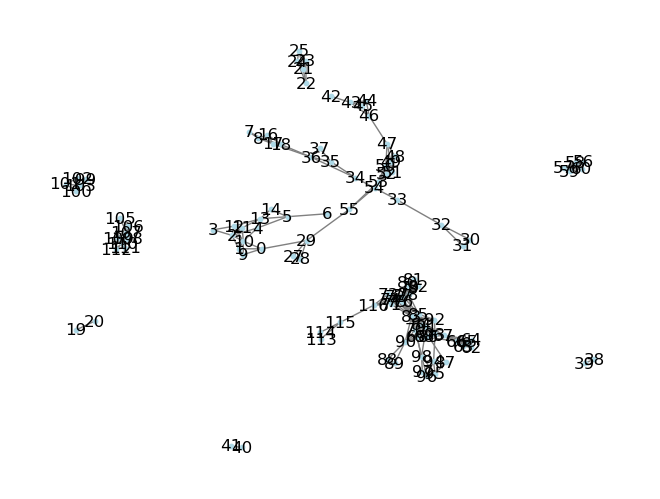

In [54]:
nx.draw(G, with_labels=True, node_size=10, node_color='lightblue', edge_color='gray')

In [42]:
len(not_in_giant)

55